# Why this Competition?
This competition provides an unique oppertunity for Data Science begiiners to participate in a Hackathon style challenge for Data Science and compete for potentiaql oppertunities in many reputed companies. It also provides the unique oppertunities for beginners to get their hands dirty and indulge is practical application of ML and do one of the basic tasks machine learning algorithms are capable of doing:- **Classification**.

# Problem Statement
Our client (FinMan Company) wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. A policy is recommended to a person when they land on their website, and if the person chooses to fill up a form to apply it is considered as a Positive outcome (Classified as lead). All other conditions are considered Zero outcomes.

## Data Description:-
We have the following information regarding the potential-customer and the insurance at any given point in time:
* Demographics (city, age, region etc.)
* Information regarding holding policies of the customer
* Recommended Policy Information

## Expected Outcome:-
* Build a model to predict whether the person will be interested in their proposed Health plan/policy given the information above.
* Grading Metric: **ROC_AUC_SCORE**

## Problem Category:-
For the data and objective its is evident that this is a **Binary Classification Problem** in the **Tabular Data** format.

So without further ado, let's now start with some basic imports to take us through this journey of Lead prediction:-

In [1]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
from functools import partial
from scipy.optimize import fmin as scip_fmin
from tqdm import tqdm
import statistics
import tempfile

# Visialisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from PIL import Image

# Machine Learning
# Utils
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split, KFold
from sklearn import preprocessing
import category_encoders as ce
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import impute
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import base
#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile, VarianceThreshold
from sklearn.decomposition import TruncatedSVD
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
#Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [2]:
data_dir = '.\Data'

train_file_path = os.path.join(data_dir, 'train_Df64byy.csv')
test_file_path = os.path.join(data_dir, 'test_YCcRUnU.csv')
sample_sub_file_path = os.path.join(data_dir, 'sample_submission_QrCyCoT.csv')

print(f'Train file: {train_file_path}')
print(f'Train file: {test_file_path}')
print(f'Train file: {sample_sub_file_path}')

Train file: .\Data\train_Df64byy.csv
Train file: .\Data\test_YCcRUnU.csv
Train file: .\Data\sample_submission_QrCyCoT.csv


In [3]:
RANDOM_SEED = 42

In [4]:
def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [5]:
seed_everything()

# EDA
Let's have a basic look around the data we have at hand first

In [6]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
sub_df = pd.read_csv(sample_sub_file_path)

Let's see what columns we have in the training data.

In [7]:
train_df.sample(10)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
19808,19809,C4,3283,Rented,Individual,25,25,No,X2,NaN,NaN,14,7068.0,0
17700,17701,C4,1308,Rented,Individual,23,23,No,X1,NaN,NaN,22,4080.0,0
24039,24040,C2,168,Rented,Joint,26,24,Yes,X2,1.0,3.0,13,16486.4,0
23029,23030,C2,256,Rented,Individual,54,54,No,X4,11.0,1.0,22,19214.0,1
44332,44333,C7,4006,Owned,Individual,75,75,No,X3,3.0,3.0,21,20376.0,0
22557,22558,C9,1863,Owned,Individual,67,67,No,X2,2.0,4.0,4,19584.0,0
2541,2542,C3,3706,Owned,Individual,51,51,No,X2,10.0,3.0,21,12820.0,0
43789,43790,C9,1376,Rented,Individual,74,74,No,X6,NaN,NaN,20,23358.0,0
14224,14225,C9,2172,Rented,Individual,53,53,No,X1,14+,2.0,6,11178.0,0
9531,9532,C3,258,Rented,Individual,25,25,No,NaN,NaN,NaN,21,11358.0,1


In [8]:
train_df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

From the column keys in problem statement we know the following information about each of the features:-

 Variable      | Definition         
 :-----------  |:------------
 ID	Unique | Identifier for a row
City_Code |	Code for the City of the customers
Region_Code | Code for the Region of the customers
Accomodation_Type |	Customer Owns or Rents the house
Reco_Insurance_Type | Joint or Individual type for the recommended insurance  
Upper_Age |	Maximum age of the customer 
Lower_Age |	Minimum age of the customer
Is_Spouse | If the customers are married to each other (in case of joint insurance) 
Health_Indicator | Encoded values for health of the customer
Holding_Policy_Duration | Duration (in years) of holding policy (a policy that customer has already subscribed to with the company)
Holding_Policy_Type | Type of holding policy
Reco_Policy_Cat	| Encoded value for recommended health insurance
Reco_Policy_Premium	Annual | Premium (INR) for the recommended health insurance
Response (Target) |	0 : Customer did not show interest in the recommended policy,
| 1 : Customer showed interest in the recommended policy

We can get a naive idea about the type of variables form the definition itself and looking at the data makes it clearer.

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,50882.0,25441.500000,14688.512535,1.0,12721.25,25441.5,38161.75,50882.0
Region_Code,50882.0,1732.788707,1424.081652,1.0,523.00,1391.0,2667.00,6194.0
Upper_Age,50882.0,44.856275,17.310271,18.0,28.00,44.0,59.00,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.00,40.0,57.00,75.0
Holding_Policy_Type,30631.0,2.439228,1.025923,1.0,1.00,3.0,3.00,4.0
Reco_Policy_Cat,50882.0,15.115188,6.340663,1.0,12.00,17.0,20.00,22.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.00,13178.0,18096.00,43350.4
Response,50882.0,0.239947,0.427055,0.0,0.00,0.0,0.00,1.0


We can see that there are some Null values in some columns. Which is not good for data ingestion into any model, so let's see the Null situation upfront:-  
## 1. Null Values

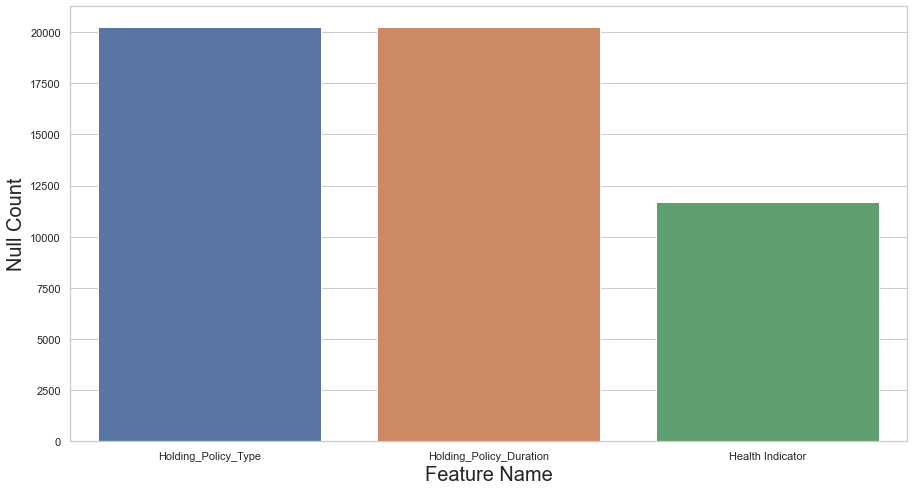

There are 3 features with missing values in the training data.
Columns containing nulls are: ['Holding_Policy_Type', 'Holding_Policy_Duration', 'Health Indicator']


In [10]:
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null Count", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the training data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

That's a lot of null values. Let's see what that looks like from a percentage stand point.

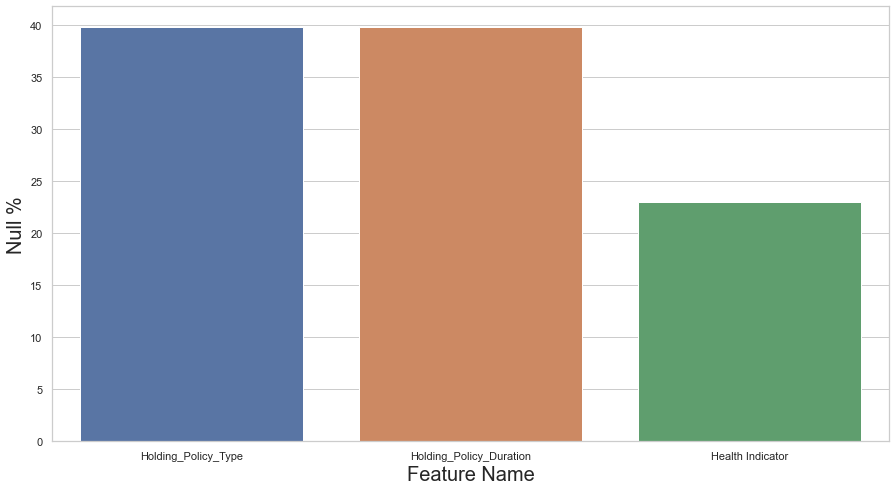

In [11]:
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/train_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

So almost 40% values in 'Holding_Policy_Duration' and 'Holding_Policy_Type' and about 22% values in 'Health Indicator' are nulls. Let's explore what is the situation in Test data:-

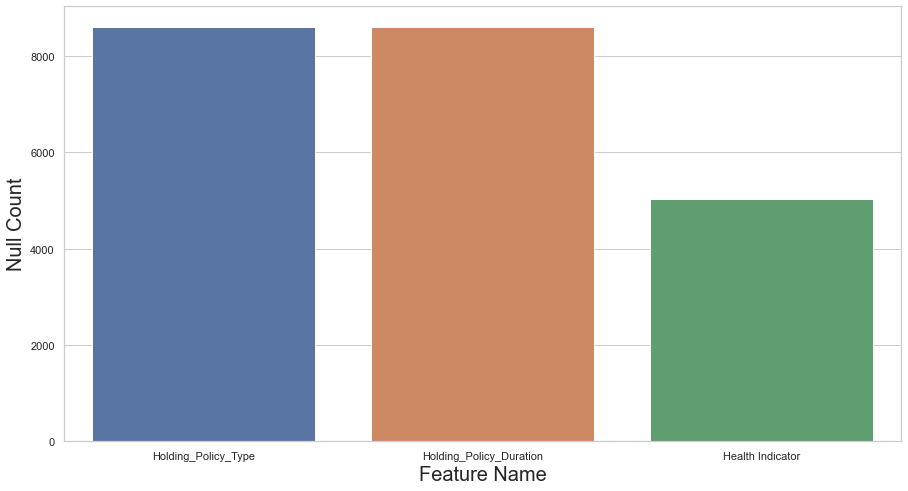

There are 3 features with missing values in the test data.
Columns containing nulls are: ['Holding_Policy_Type', 'Holding_Policy_Duration', 'Health Indicator']


In [12]:
nulls_train = np.sum(test_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null Count", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the test data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

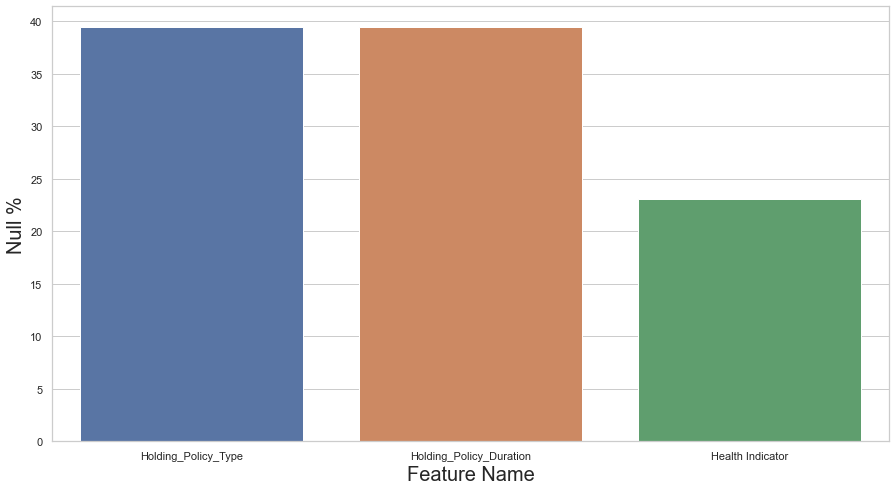

In [13]:
nulls_train = np.sum(test_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/test_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

The situation is almost similar in test set as well. And looking at the feature definition of the missing values I have a hunch that these values are absent because those people are not current customers of the company. Let's look at them one by one:-  
### A. Holding_Policy_Duration

In [14]:
print(list(train_df['Holding_Policy_Duration'].unique()))

['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0', '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0']


As we suspected the only zero non-number value in the entire range of values in NaN. Thus it can be inferred that those values are pertaining to non-existing customers. And we can fill them up by 0.

In [15]:
train_df['Holding_Policy_Duration'].fillna(0, inplace=True)
test_df['Holding_Policy_Duration'].fillna(0, inplace=True)

### B. Holding_Policy_Type

In [16]:
print(list(train_df['Holding_Policy_Type'].unique()))

[3.0, nan, 1.0, 4.0, 2.0]


Because the counts of 'Holding_Policy_Type' and 'Holding_Policy_Duration' are similar and like 'Holding_Policy_Duration' there are no indicator of non-existing customers in the 'Holding_Policy_Type' column it can be easily inferred that those are the same customersd and we can assign a type from out side. Let's call them '0'.

In [17]:
train_df['Holding_Policy_Type'].fillna(0, inplace=True)
test_df['Holding_Policy_Type'].fillna(0, inplace=True)

### C. Health Indicator
Unlike the previous two, health indicator is a bit tricky. It can be assumed that this value was derived from pre-existing metric based on some empirical calculations like BMI wherein the user had to enter their details. And this variable can be null when the user decided not to fill those values. There is nothing much we can do about it. Let's pill the NaN with the most common value in that category.

In [18]:
print(list(train_df['Health Indicator'].unique()))

['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9']


Let's fill the missing values with mode.

In [19]:
train_df['Health Indicator'].fillna(train_df['Health Indicator'].mode()[0], inplace=True)
test_df['Health Indicator'].fillna(test_df['Health Indicator'].mode()[0], inplace=True)

In [20]:
np.sum(train_df.isnull())

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
dtype: int64

In [21]:
np.sum(test_df.isnull())

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
dtype: int64

Now we can say that the data is "Nulls' free.  
Now, since it's a classification problem, let's look at the class imbalance of the training set as it will impact the choice and approach of the model largely.  
## 2. Class Imbalance

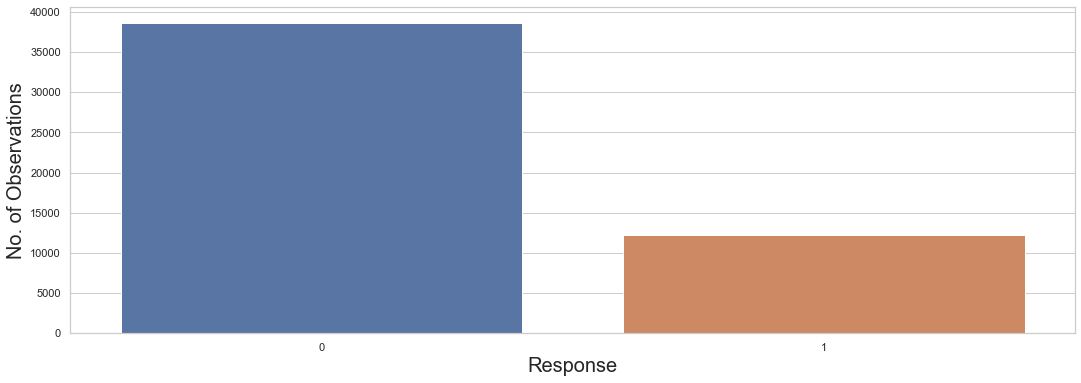

In [22]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Response', data=train_df);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Response", size=20);

Okay, so it is an imbalanced set. We have to keep that in mind while modelling and choosing hyper-parameters later.  
## 3. Feature Value Counts

In [23]:
train_df.nunique()

ID                         50882
City_Code                     36
Region_Code                 5316
Accomodation_Type              2
Reco_Insurance_Type            2
Upper_Age                     58
Lower_Age                     60
Is_Spouse                      2
Health Indicator               9
Holding_Policy_Duration       16
Holding_Policy_Type            5
Reco_Policy_Cat               22
Reco_Policy_Premium         6977
Response                       2
dtype: int64

## 4. Recommended Policy Premium

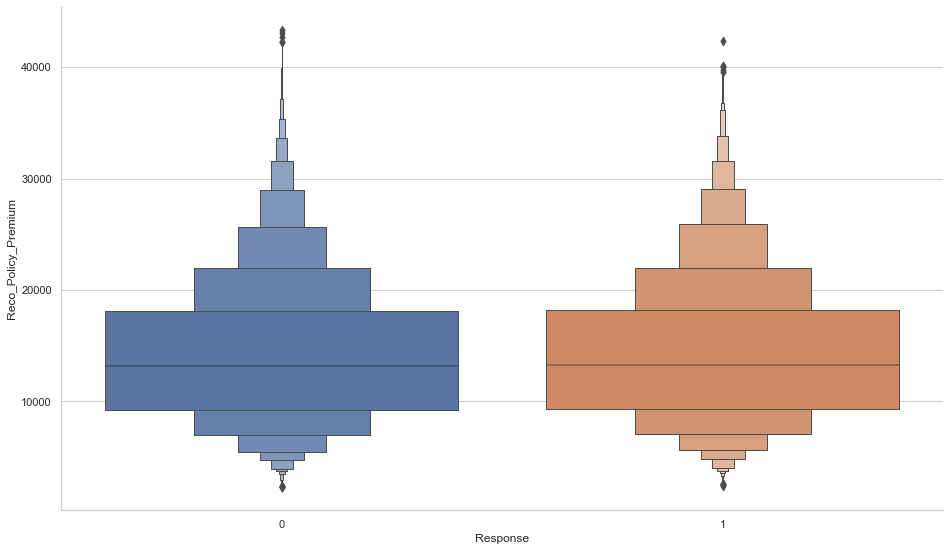

In [24]:
g = sns.catplot(x='Response', y='Reco_Policy_Premium', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

The distribution of premium price of recommended policy is sort of similar between a lead and no-lead customer. But one other way of looking at this might be:- 'What if the person felt that the premium is too high for a particular category of policy?'  
So let's take that into account as well...

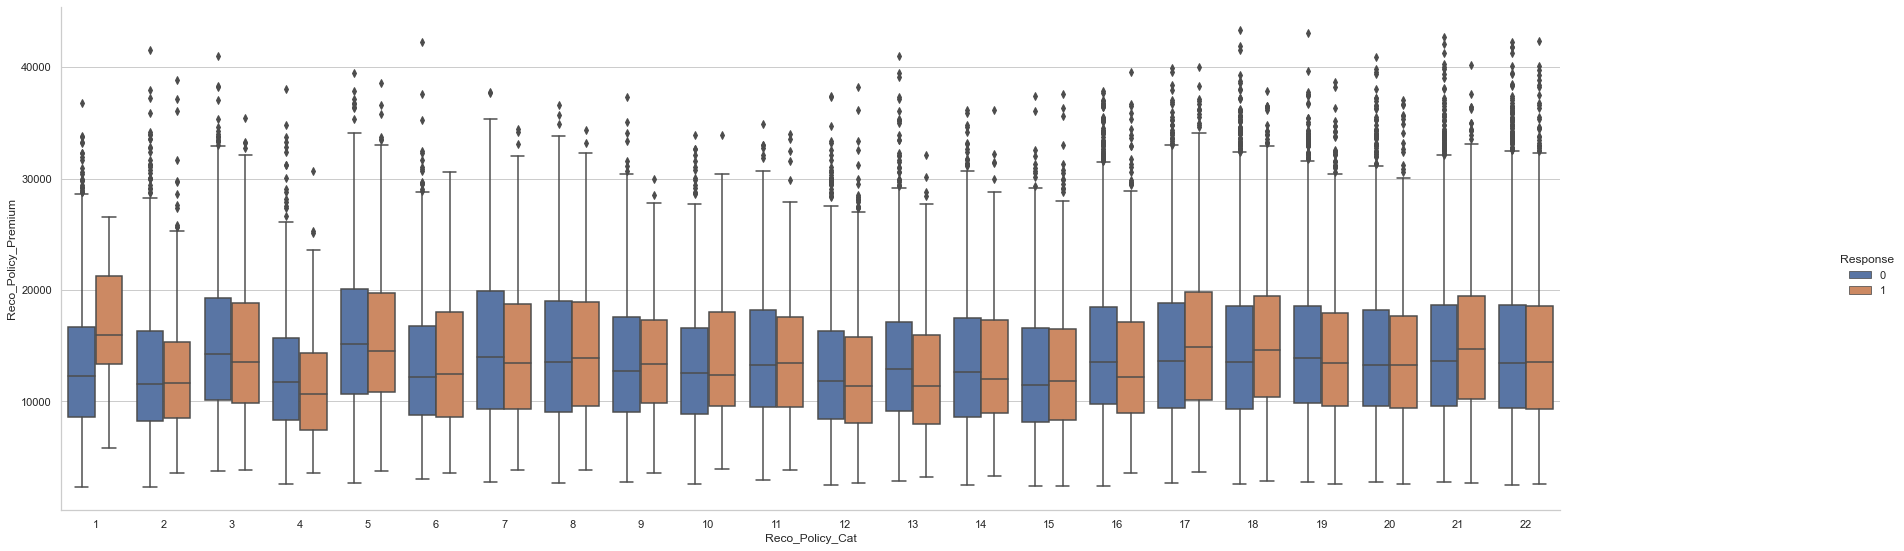

In [25]:
g = sns.catplot(x='Reco_Policy_Cat', y='Reco_Policy_Premium', hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(30,8)

Similarly, for 'Reco_Insurance_Type' :-

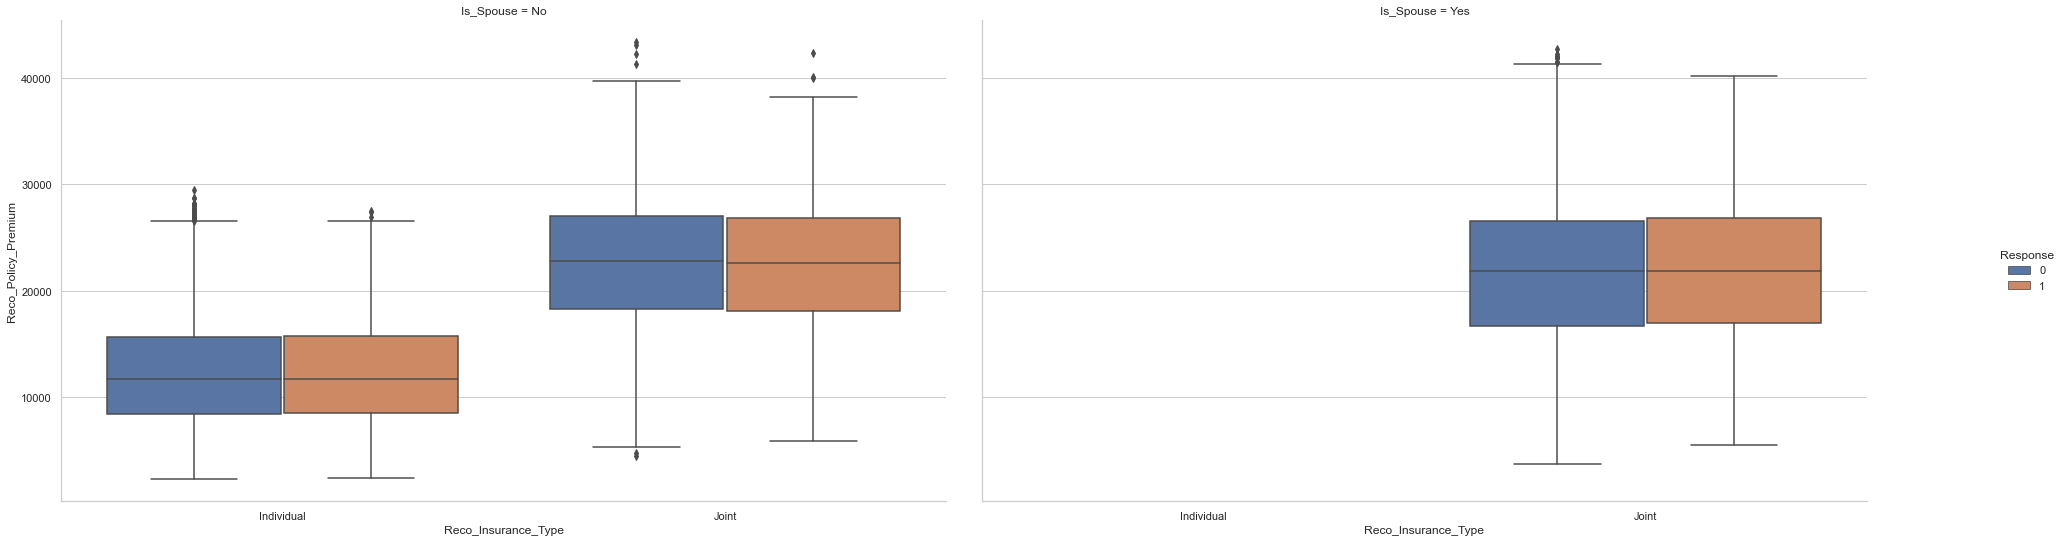

In [26]:
g = sns.catplot(x='Reco_Insurance_Type', y='Reco_Policy_Premium', col='Is_Spouse' ,hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(30,8)

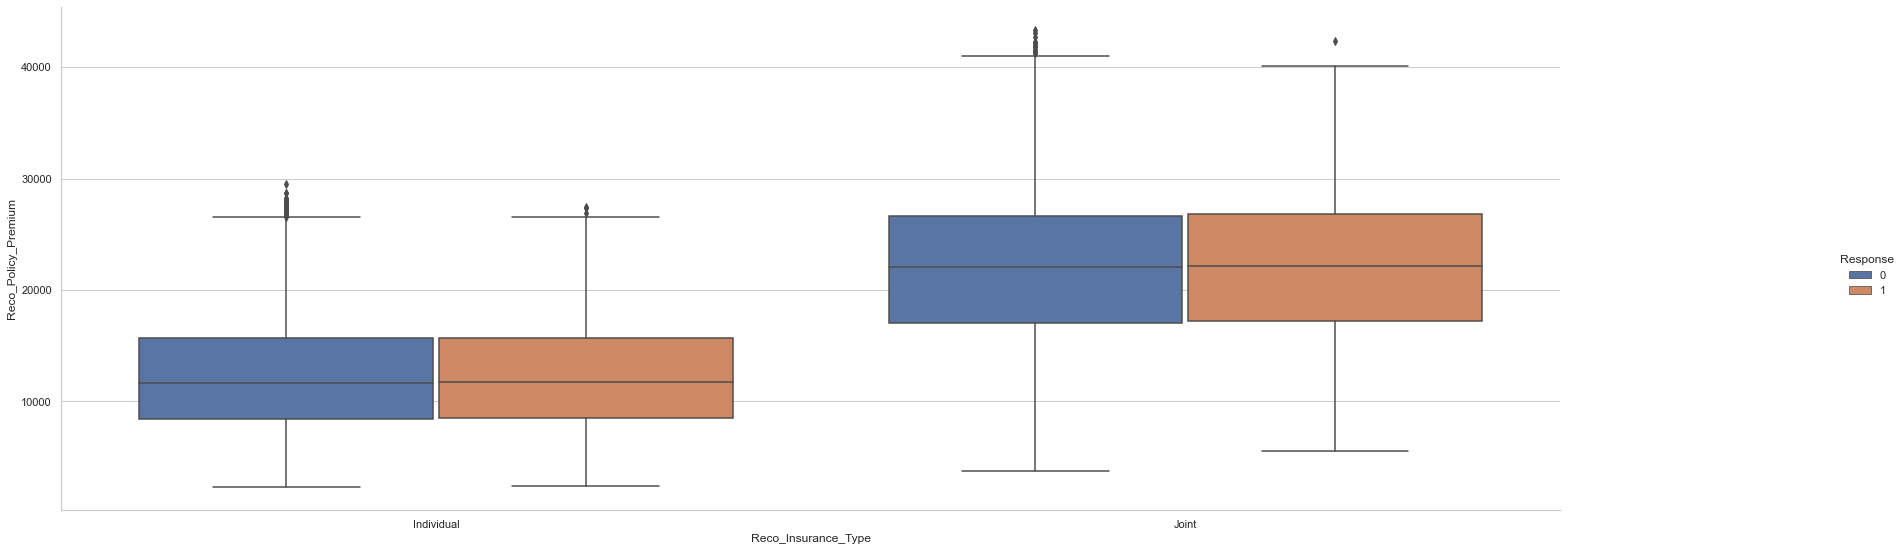

In [27]:
g = sns.catplot(x='Reco_Insurance_Type', y='Reco_Policy_Premium', hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(30,8)

Ok, so we see that there are certain policies (type = 3, 13, 16, etc) where we can assume the high premium for that class of policy might be one of the reasons for the lead going cold. However Insurance type has little to no effect on it's own.  
## 5. Age

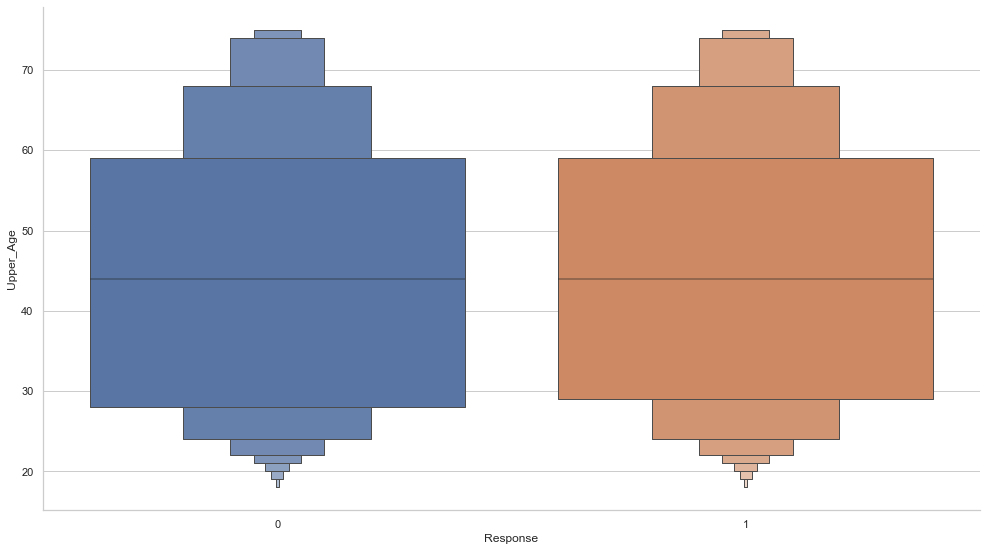

In [28]:
g = sns.catplot(x='Response', y='Upper_Age', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

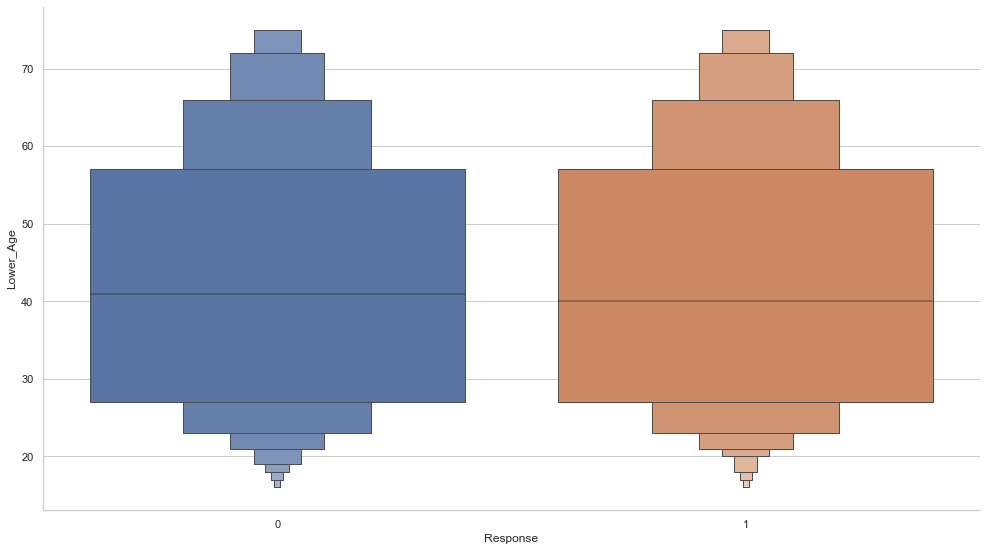

In [29]:
g = sns.catplot(x='Response', y='Lower_Age', kind='boxen', data=train_df);
g.fig.set_size_inches(15,8)

So we can infer that the upper and Lower age of customer on it's own has a very little impact on the type of response we can get. But's let's try to factor in the health condition as well.

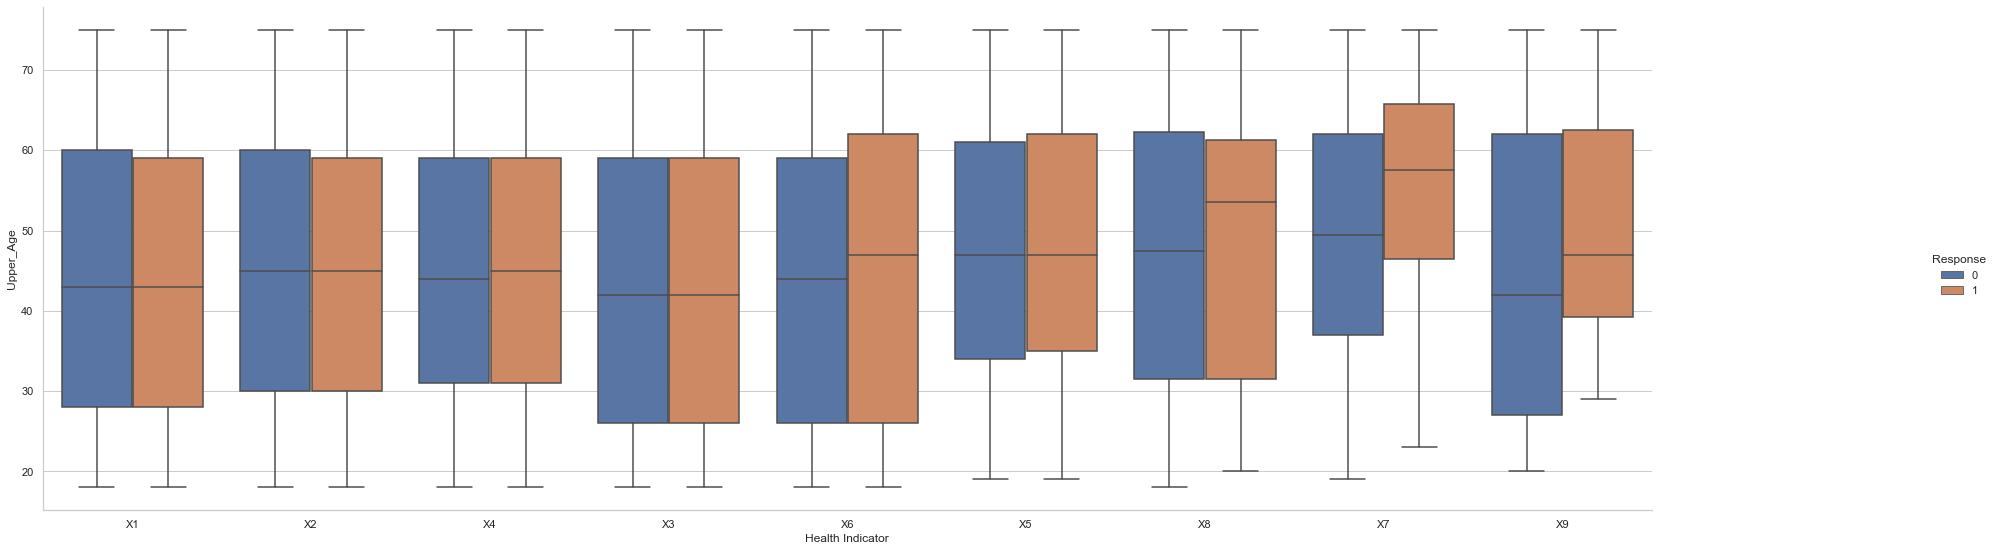

In [30]:
g = sns.catplot(x='Health Indicator', y='Upper_Age', hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(30,8)

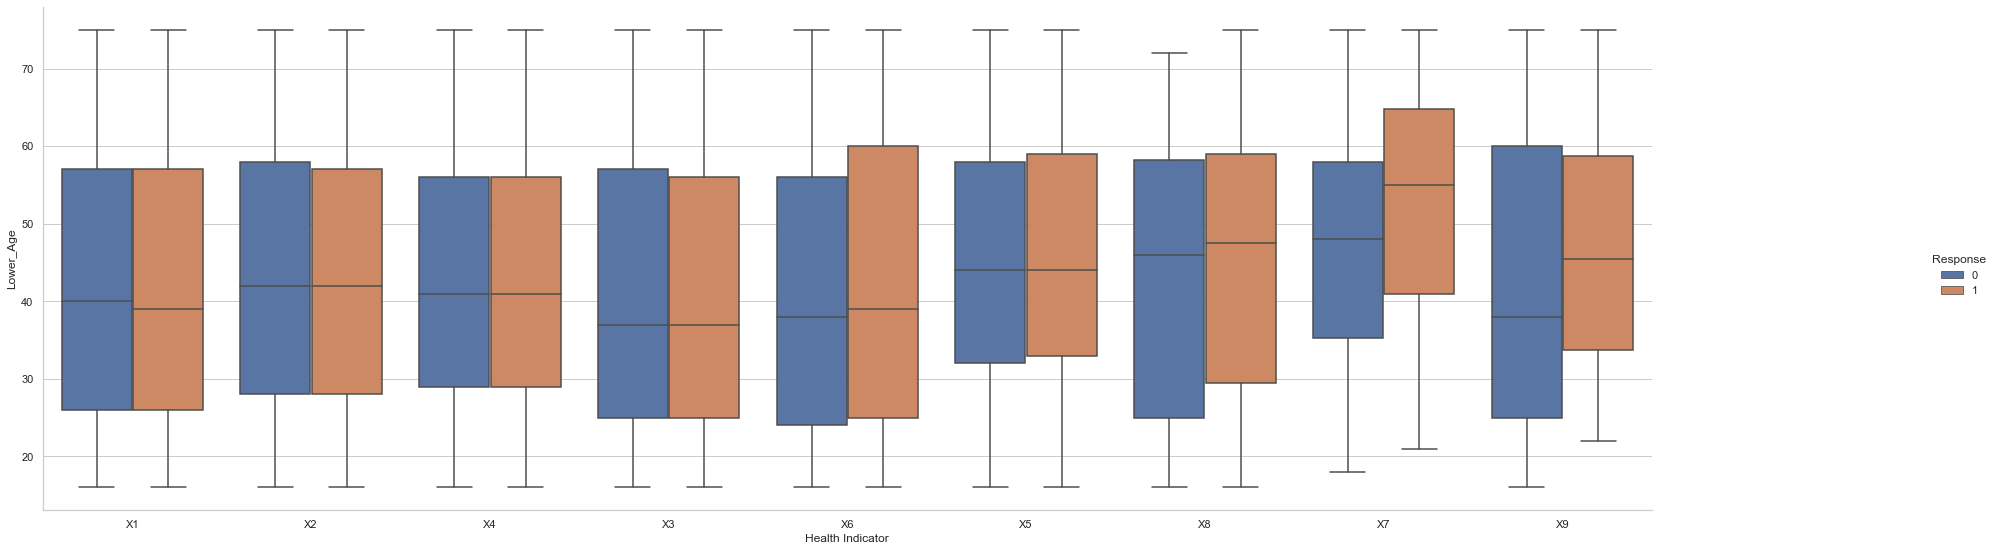

In [31]:
g = sns.catplot(x='Health Indicator', y='Lower_Age', hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(30,8)

**Interesting! So we can infer that there are certain health conditions like X7, X8 and X9 where the chances of getting a positive response is higher only after a particular age limit.**  
## 6. City Code

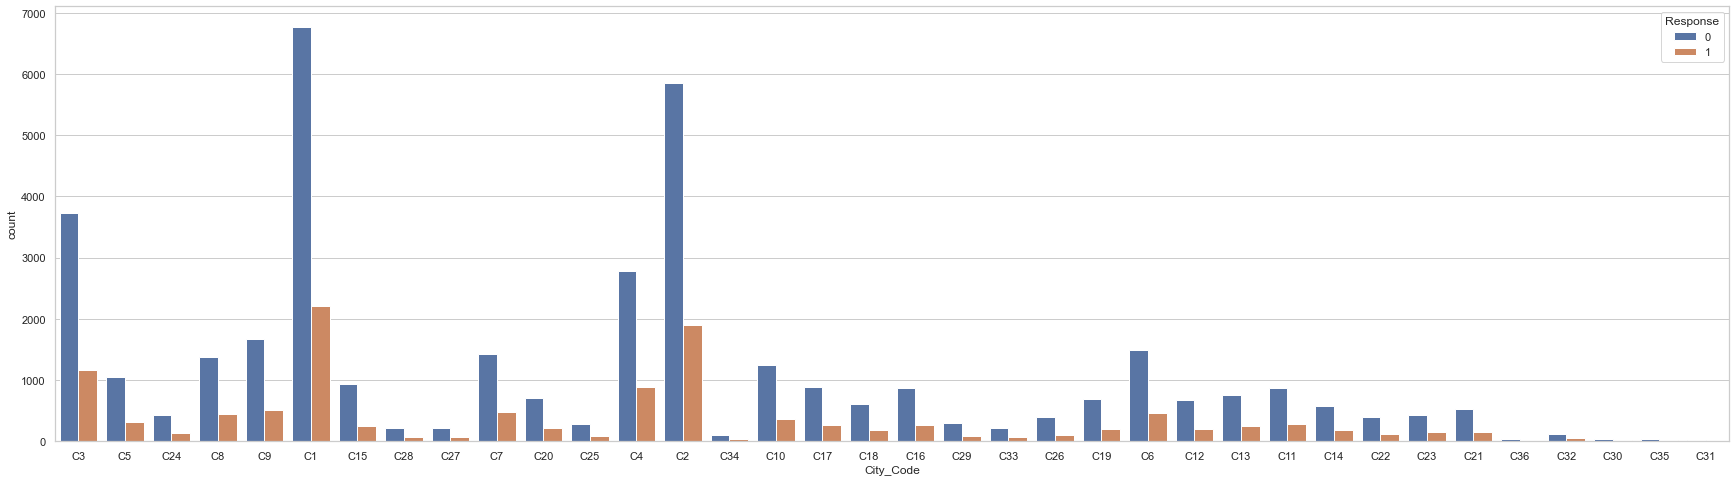

In [32]:
ax = plt.subplots(figsize=(30, 8))
sns.set_style("whitegrid")
sns.countplot(x='City_Code', hue='Response', data=train_df);

In [33]:
# Response Rate from Cities
v = train_df.groupby('City_Code').Response.value_counts().unstack()
v['Ratio'] = v[1]/v[0]
v.reset_index(inplace=True)

In [34]:
v['Ratio'].mean()

0.3138788755812376

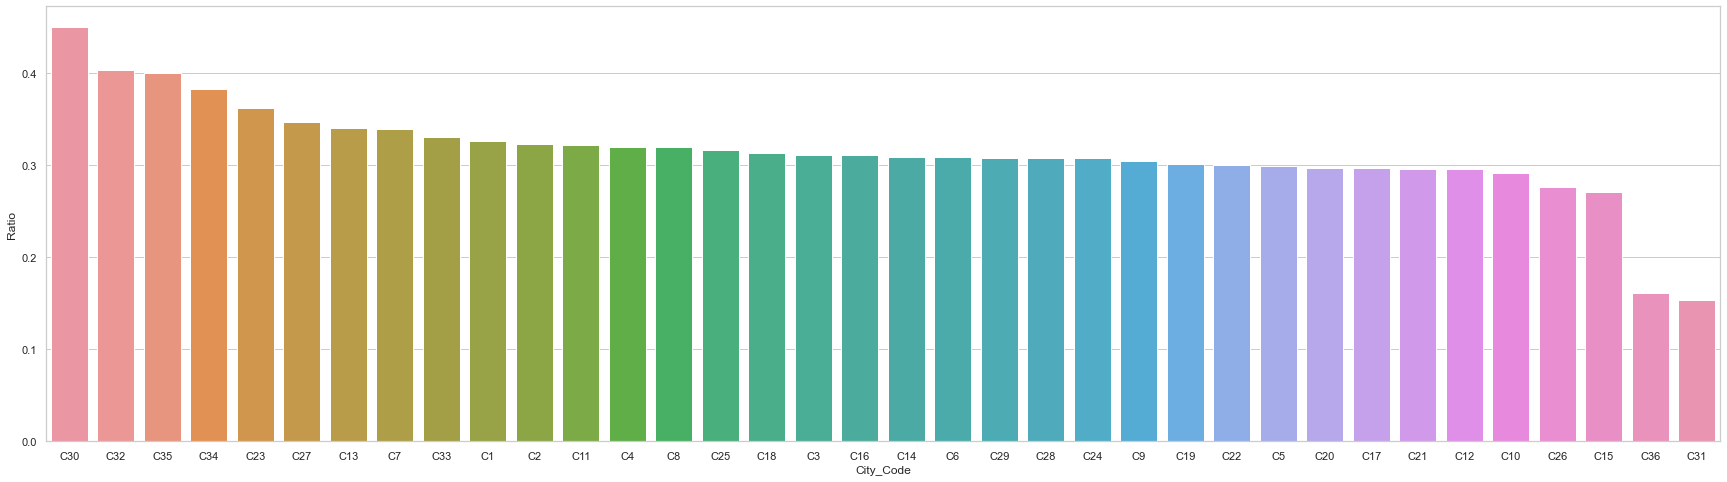

In [35]:
ax = plt.subplots(figsize=(30, 8))
sns.set_style("whitegrid")
sns.barplot(x='City_Code', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

The lean to non-lead ratio in every city is below 1, i.e, there are more no-leads as comapred to leads in each and every city. But there are certain cities which perrform better than average like C30, C32, etc.  
## 7. Accomodation_Type

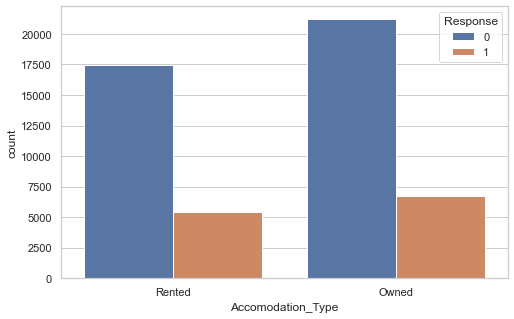

In [36]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Accomodation_Type', hue='Response', data=train_df);

In [37]:
# Response Rate from Accomodation Types
v = train_df.groupby('Accomodation_Type').Response.value_counts().unstack()
v['Ratio'] = v[1]/v[0]
v.reset_index(inplace=True)

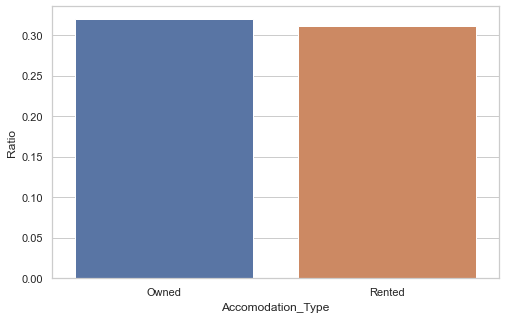

In [38]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Accomodation_Type', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

Both accomodation types have a similarish response, with home owners slightly more favorable to be leads. What if we combine accomodation_type with Insurance premium. Because logically it should ahve an effect...

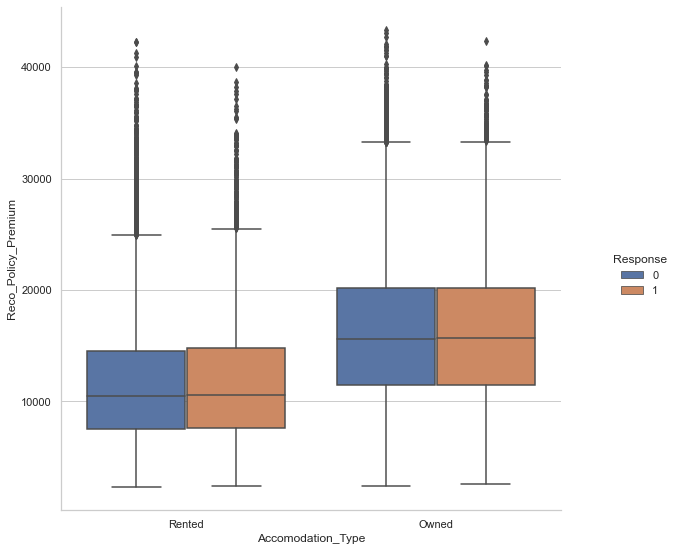

In [39]:
g = sns.catplot(x='Accomodation_Type', y='Reco_Policy_Premium', hue='Response', kind='box', data=train_df);
g.fig.set_size_inches(10,8)

People renting homes are less likely to buy insurances if the premium is too high.  
## 8. Existing vs New Customer
As we inferred earlier, people having 'Holding_Policy_Duration' as NaN (imputed with 0) are most likely to be new customers. So let's create a synthetic feature signifying the same.

In [40]:
train_df['Cust_Type'] = train_df['Holding_Policy_Duration'].apply(lambda x : 'New' if x==0 else 'Old')
test_df['Cust_Type'] = test_df['Holding_Policy_Duration'].apply(lambda x : 'New' if x==0 else 'Old')

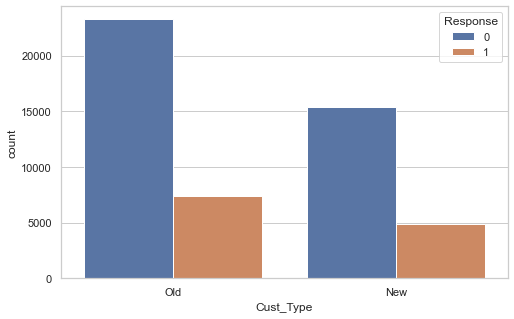

In [41]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Cust_Type', hue='Response', data=train_df);

In [42]:
# Response Rate from Customer Types
v = train_df.groupby('Cust_Type').Response.value_counts().unstack()
v['Ratio'] = v[1]/v[0]
v.reset_index(inplace=True)

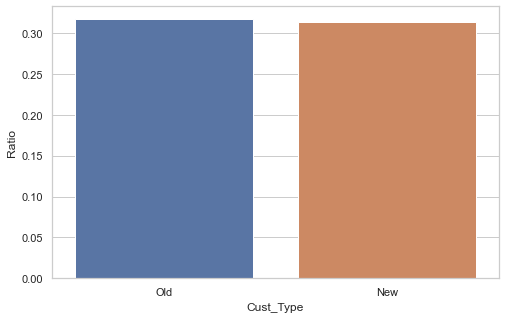

In [43]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='Cust_Type', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

An older customer is slightly more likely to take up an offered insurance as compared to new ones.  
From the inference of single and bi feature EDA it is evident that there is no clearcut single variable responsible for determining the final class. So it is going to be a uphill task to separate the two clusters.  
Now let's move to feature engineering and Feature selection part..  
## 9. Numerical Features Distribution
Let's explore the relationship of each numerical variable with one another

In [44]:
target = ['Response']
not_features = ['ID', 'Response', 'kfold']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Cust_Type']


In [45]:
categorical_features = [
    'City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Region_Code',
    'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat',
    'Cust_Type'
]
numerical_features = [feat for feat in features if feat not in categorical_features]

print(f'Categorical Features: {categorical_features}')
print(f'Numeric Features: {numerical_features}')

Categorical Features: ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Region_Code', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Cust_Type']
Numeric Features: ['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium']


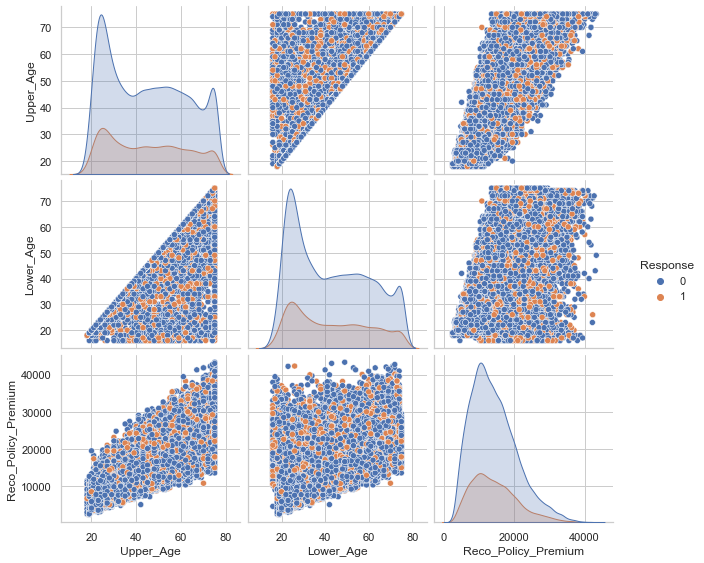

In [46]:
g = sns.pairplot(train_df[numerical_features + ['Response']], hue='Response')
g.fig.set_size_inches(10,8)

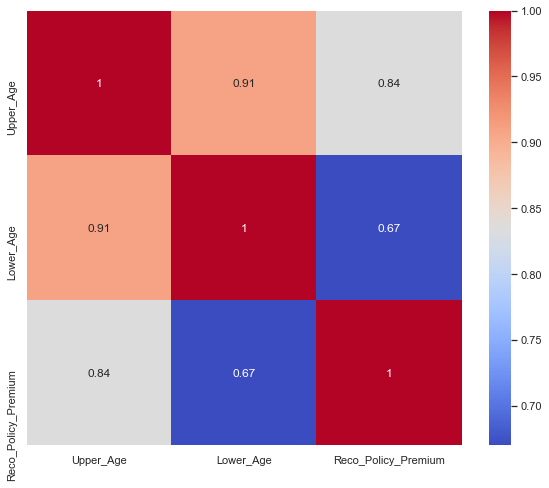

In [47]:
train_df_cor_spear = train_df[numerical_features].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(train_df_cor_spear, square=True, cmap='coolwarm', annot=True);

The recommended policy premium rises with Age.  
## 10. Numerical Features Quartiles

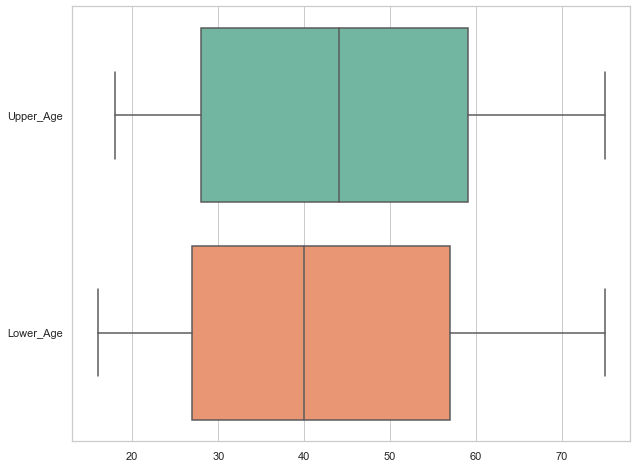

In [48]:
plt.figure(figsize=(10,8))
sns.boxplot(data=train_df[['Upper_Age', 'Lower_Age']], orient="h", palette="Set2");

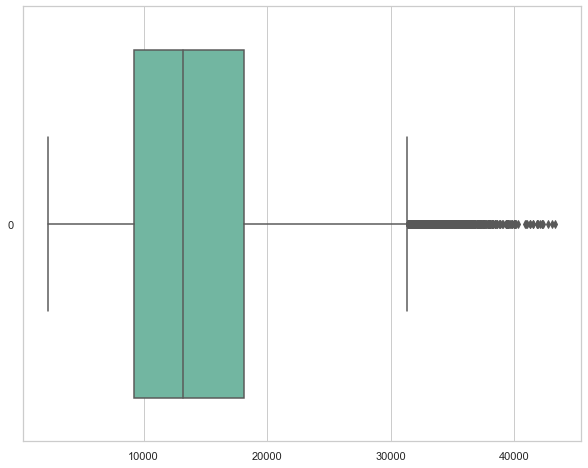

In [49]:
plt.figure(figsize=(10,8))
sns.boxplot(data=train_df['Reco_Policy_Premium'], orient="h", palette="Set2");

Reco_Policy_Premium has a long tail. We can take logarithm of the feature to reduce the impact of outliers.  
## 11. Categorical Feature Counts

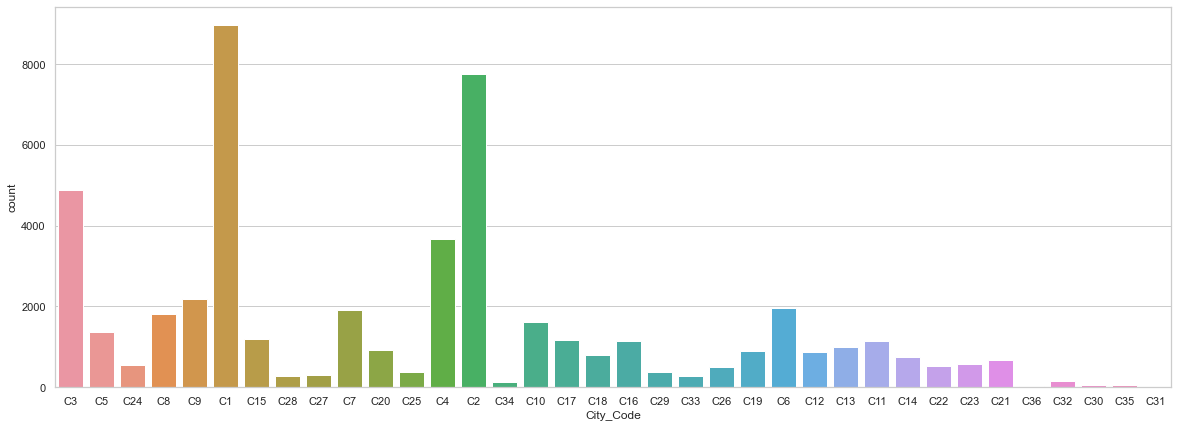

In [50]:
ax = plt.subplots(figsize=(20, 7))
sns.set_style("whitegrid")
sns.countplot(x='City_Code', data=train_df);

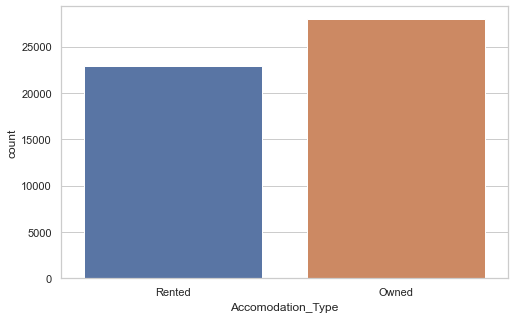

In [51]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Accomodation_Type', data=train_df);

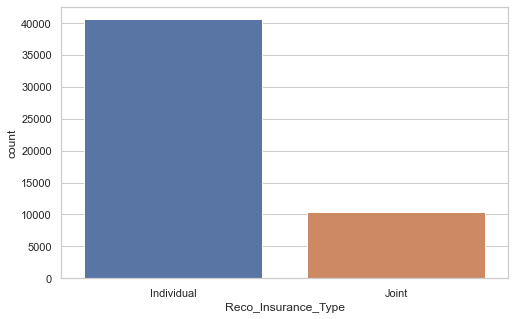

In [52]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Reco_Insurance_Type', data=train_df);

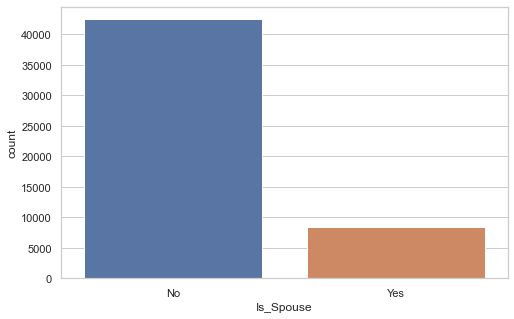

In [53]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Is_Spouse', data=train_df);

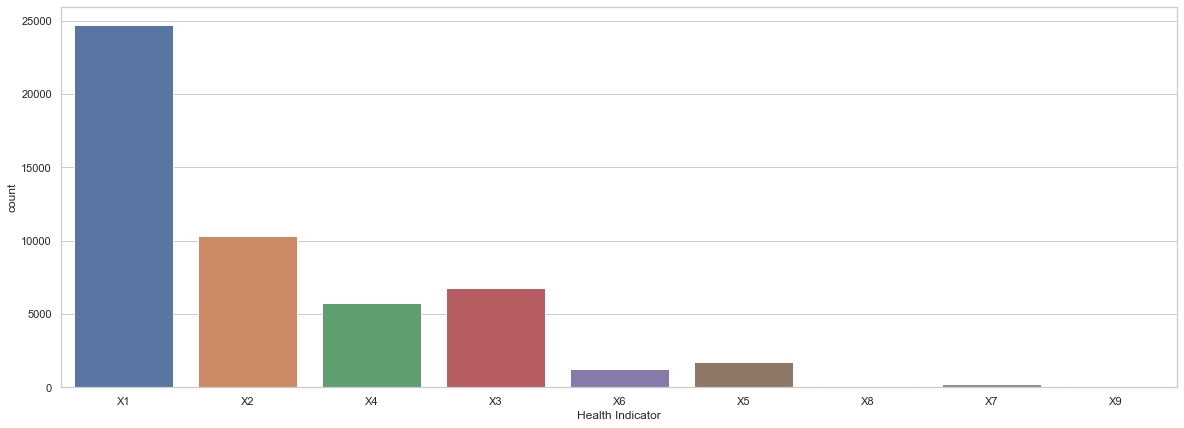

In [54]:
ax = plt.subplots(figsize=(20, 7))
sns.set_style("whitegrid")
sns.countplot(x='Health Indicator', data=train_df);

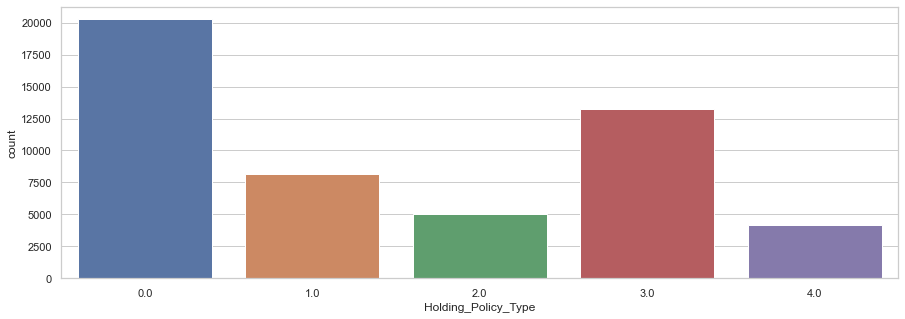

In [55]:
ax = plt.subplots(figsize=(15, 5))
sns.set_style("whitegrid")
sns.countplot(x='Holding_Policy_Type', data=train_df);

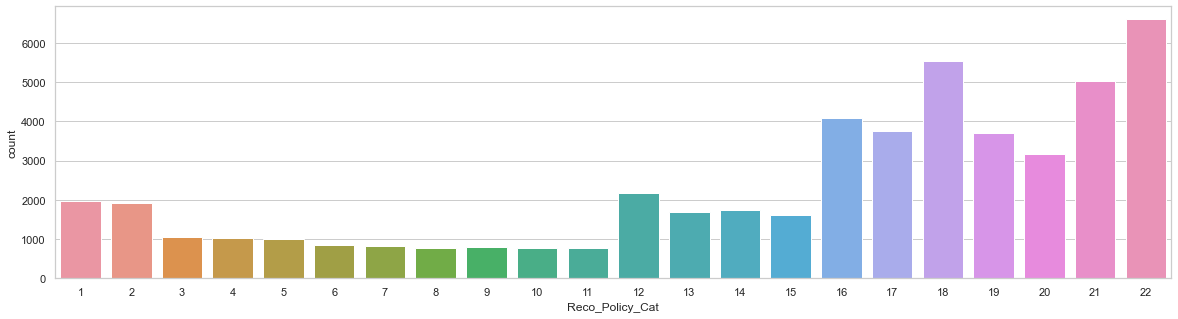

In [56]:
ax = plt.subplots(figsize=(20, 5))
sns.set_style("whitegrid")
sns.countplot(x='Reco_Policy_Cat', data=train_df);

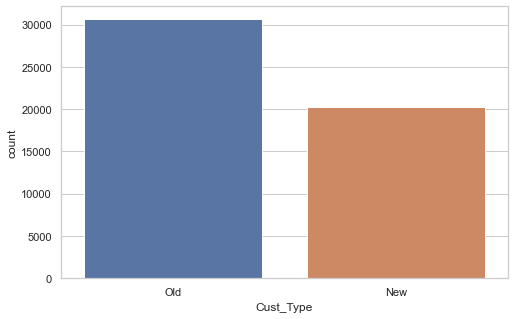

In [57]:
ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
sns.countplot(x='Cust_Type', data=train_df);

# KFold Splits  
Before we move on to feature engineering, it is always a good idea to perform cross validation splits. In that way, we will not rix any data leakage and would be more certain of the validation set being aptly represenative of the real world unknown data.

In [58]:
NUM_SPLITS = 5

train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.Response.values
kf = StratifiedKFold(n_splits=NUM_SPLITS)
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
    train_df.loc[v_, 'kfold'] = f
    
train_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Cust_Type,kfold
0,46414,C4,191,Owned,Individual,57,57,No,X1,8.0,3.0,9,12860.0,0,Old,0
1,12112,C4,3383,Owned,Individual,26,26,No,X2,0,0.0,8,5016.0,1,New,0
2,3558,C1,906,Rented,Individual,21,21,No,X1,0,0.0,20,6680.0,0,New,0
3,29725,C2,3024,Owned,Joint,58,52,Yes,X1,0,0.0,22,23254.0,0,New,0
4,25707,C3,482,Rented,Individual,71,71,No,X1,4.0,1.0,2,17444.0,1,Old,0


# Feature Engineering

## 1. Age Confidence Interval
Since we have a upper and lowe limit for age we can create a confidence interval for the age.

In [59]:
train_df['Age_Conf_Interval'] = train_df['Upper_Age'] - train_df['Lower_Age']
test_df['Age_Conf_Interval'] = test_df['Upper_Age'] - test_df['Lower_Age']

## 2. Long Term Customer
We can create a synthetic variable saying if the person is a long term customer of the company.

In [60]:
train_df['Long_Term_Cust'] = train_df['Holding_Policy_Duration'].apply(lambda x : 'Yes' if x=='14+' else 'No')
test_df['Long_Term_Cust'] = test_df['Holding_Policy_Duration'].apply(lambda x : 'Yes' if x=='14+' else 'No')

## 3. Recommended Policy Price Log

In [61]:
train_df['Reco_Policy_Premium_log'] = np.log(train_df['Reco_Policy_Premium'])
test_df['Reco_Policy_Premium_log'] = np.log(test_df['Reco_Policy_Premium'])

## 4. Mean Age

In [62]:
train_df['Mean_Age'] = (train_df['Upper_Age'] + train_df['Upper_Age'])/2
test_df['Mean_Age'] = (test_df['Upper_Age'] + test_df['Upper_Age'])/2

## 5. Premium to Age Ratio

In [63]:
train_df['Permium_Per_Age_Year'] = np.log(train_df['Reco_Policy_Premium']/train_df['Mean_Age'])
test_df['Permium_Per_Age_Year'] = np.log(test_df['Reco_Policy_Premium']/test_df['Mean_Age'])

## 6. City Code and Region Code Combine
We can combine the city and region code to create a single variable that represents the locality

In [64]:
train_df['City_Region'] = train_df["City_Code"].astype(str) + '_' + train_df["Region_Code"].astype(str)
test_df['City_Region'] = test_df["City_Code"].astype(str) + '_' + test_df["Region_Code"].astype(str)

## 7. Customer Age Buckets
Customer ages can be bucketed and dictretized into groups.

In [65]:
train_df['Mean_Age_Bin_10'] = pd.cut(train_df['Mean_Age'], bins=10, labels=False)
train_df['Mean_Age_Bin_50'] = pd.cut(train_df['Mean_Age'], bins=50, labels=False)
test_df['Mean_Age_Bin_10'] = pd.cut(test_df['Mean_Age'], bins=10, labels=False)
test_df['Mean_Age_Bin_50'] = pd.cut(test_df['Mean_Age'], bins=50, labels=False)

## 8. Proposed Premium Buckets
Similarly proposed policy premium can be bucketed and dictretized into groups.

In [66]:
train_df['Reco_Policy_Premium_Bin_10'] = pd.cut(train_df['Reco_Policy_Premium'], bins=10, labels=False)
train_df['Reco_Policy_Premium_Bin_50'] = pd.cut(train_df['Reco_Policy_Premium'], bins=50, labels=False)
test_df['Reco_Policy_Premium_Bin_10'] = pd.cut(test_df['Reco_Policy_Premium'], bins=10, labels=False)
test_df['Reco_Policy_Premium_Bin_50'] = pd.cut(test_df['Reco_Policy_Premium'], bins=50, labels=False)

## 9. Joint But Not Spouse
There are some people who were offered Joint insurance, but not with their spouse. Let's call that member Family.

In [67]:
def return_type_def(x):
    if (x['Reco_Insurance_Type'] == 'Joint') and (x['Is_Spouse'] == 'No'):
        return 'Family'
    else:
        return x['Reco_Insurance_Type']

In [68]:
train_df['Offered_With'] = train_df[['Reco_Insurance_Type', 'Is_Spouse']].apply(return_type_def, axis=1)
test_df['Offered_With'] = test_df[['Reco_Insurance_Type', 'Is_Spouse']].apply(return_type_def, axis=1)

train_df['Offered_With'] = train_df['Offered_With'].replace('Joint', 'Spouse')
test_df['Offered_With'] = test_df['Offered_With'].replace('Joint', 'Spouse')

train_df['Offered_With'] = train_df['Offered_With'].replace('Individual', 'Self')
test_df['Offered_With'] = test_df['Offered_With'].replace('Individual', 'Self')

## 10. Join City and Accomodation Type
Which in practical sense means 'Renting a home in Mumbai' (for example)

In [69]:
train_df['City_Accomodation'] = train_df["City_Code"].astype(str) + '_' + train_df["Accomodation_Type"].astype(str)
test_df['City_Accomodation'] = test_df["City_Code"].astype(str) + '_' + test_df["Accomodation_Type"].astype(str)

## 11. Recommended Policy Premium to Round Numbers
Let's convert the recommended policy premium to a whole round number so that we do not factor in the noise and trivialities in the exact number.

In [70]:
def make_whole_number(data):
    _data = str(int(data))
    _len_data = len(_data)
    _data = "".join(_data[0] + '0' * (_len_data-1))
    return int(_data)

In [71]:
train_df['Reco_Policy_Premium_Round'] = train_df['Reco_Policy_Premium'].apply(make_whole_number)
test_df['Reco_Policy_Premium_Round'] = test_df['Reco_Policy_Premium'].apply(make_whole_number)

# Features Encoding
Irrespective of the column datatype, we can split the data based on their definition into categorical and Numeric Data types.

In [72]:
target = ['Response']
not_features = ['ID', 'Response', 'kfold']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Cust_Type', 'Age_Conf_Interval', 'Long_Term_Cust', 'Reco_Policy_Premium_log', 'Mean_Age', 'Permium_Per_Age_Year', 'City_Region', 'Mean_Age_Bin_10', 'Mean_Age_Bin_50', 'Reco_Policy_Premium_Bin_10', 'Reco_Policy_Premium_Bin_50', 'Offered_With', 'City_Accomodation', 'Reco_Policy_Premium_Round']


In [73]:
categorical_features = [
                        'Accomodation_Type', 'Reco_Insurance_Type', 'City_Code', 'Region_Code', 
                        'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
                        'Holding_Policy_Type','Reco_Policy_Cat', 'Cust_Type', 'Long_Term_Cust',
                        'City_Region', 'Mean_Age_Bin_10', 'Mean_Age_Bin_50',
                        'Reco_Policy_Premium_Bin_10', 'Reco_Policy_Premium_Bin_50', 'Offered_With',
                        'City_Accomodation'
                        ]
numerical_features = [feat for feat in features if feat not in categorical_features]

print(f'Categorical Features: {categorical_features}')
print(f'Numeric Features: {numerical_features}')

Categorical Features: ['Accomodation_Type', 'Reco_Insurance_Type', 'City_Code', 'Region_Code', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Cust_Type', 'Long_Term_Cust', 'City_Region', 'Mean_Age_Bin_10', 'Mean_Age_Bin_50', 'Reco_Policy_Premium_Bin_10', 'Reco_Policy_Premium_Bin_50', 'Offered_With', 'City_Accomodation']
Numeric Features: ['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium', 'Age_Conf_Interval', 'Reco_Policy_Premium_log', 'Mean_Age', 'Permium_Per_Age_Year', 'Reco_Policy_Premium_Round']


In [74]:
train_df[categorical_features] = train_df[categorical_features].astype('str')
test_df[categorical_features] = test_df[categorical_features].astype('str')

Now let's convert each of the numeric column into proper datatype...

In [75]:
train_df[numerical_features] = train_df[numerical_features].astype('float64')
test_df[numerical_features] = test_df[numerical_features].astype('float64')

In [76]:
train_df[target] = train_df[target].astype('float64')

Now that the numeric features are ready, moving on to Categorical Features encoding.  
Categorical Features can be of 2 types:-  
* Nominal (No significant Order)
* Ordinal (Order is significant)  
  
So let's split them up first and encode them after.

In [77]:
nominal_cols = [
    'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type', 'City_Code',
    'Region_Code', 'Reco_Policy_Cat', 'Cust_Type', 'Long_Term_Cust', 'City_Region', 'Offered_With', 'City_Accomodation'
]
ordinal_cols = [
    'Holding_Policy_Duration', 'Mean_Age_Bin_10', 'Mean_Age_Bin_50', 'Reco_Policy_Premium_Bin_10', 'Reco_Policy_Premium_Bin_50'
]

Using Label encoding for Nominal Data and Helmhert for Ordinal Data

In [78]:
lbl_enc = preprocessing.LabelEncoder()
full_data = pd.concat(
    [train_df[categorical_features], test_df[categorical_features]],
    axis=0
)

for col in (categorical_features):
    print(col)
    if train_df[col].dtype == 'object':
        lbl_enc.fit(full_data[col].values)
        train_df[col] = lbl_enc.transform(train_df[col])
        test_df[col] = lbl_enc.transform(test_df[col])

Accomodation_Type
Reco_Insurance_Type
City_Code
Region_Code
Is_Spouse
Health Indicator
Holding_Policy_Duration
Holding_Policy_Type
Reco_Policy_Cat
Cust_Type
Long_Term_Cust
City_Region
Mean_Age_Bin_10
Mean_Age_Bin_50
Reco_Policy_Premium_Bin_10
Reco_Policy_Premium_Bin_50
Offered_With
City_Accomodation


In [79]:
# ce_helmert = ce.HelmertEncoder(cols=ordinal_cols)

# ce_helmert.fit(train_df[ordinal_cols], train_df[target])

# train_df = train_df.join(ce_helmert.transform(train_df[ordinal_cols]).add_suffix('_helm'))
# test_df = test_df.join(ce_helmert.transform(test_df[ordinal_cols]).add_suffix('_helm'))

In [80]:
# train_df = train_df.drop(ordinal_cols, axis=1)
# test_df = test_df.drop(ordinal_cols, axis=1)

# Features Selection
Now let's only select the important features to overcome the curse of dimensionality.

In [81]:
target = ['Response']
not_features = ['ID', 'Response', 'kfold']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]

In [82]:
# From https://github.com/abhishekkrthakur/approachingalmost
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features

In [83]:
ufs = UnivariateFeatureSelction(
    n_features=0.9,
    problem_type="classification",
    scoring="f_classif"
)

ufs.fit(train_df[features], train_df[target].values.ravel())
# X_transformed = ufs.transform(train_df[features])
selected_features = ufs.return_cols(train_df[features])

# Utils

In [84]:
def rate_model(clf, x, cv = StratifiedKFold(n_splits=NUM_SPLITS),
               fold=0, features=selected_features, target=target):
    '''
    Prints out various evaluation metrics for a classification task. Like:-
    1. Classification Accuracy
    2. ROC-AUC Score
    3. Precision
    4. Recall
    5. F1 Score
    6. Confusion matrix
    All score are calculated in base format. No averaging is performed.
    
    clf - Classification Model
    x - Input features
    cv - Cross Validation criteria
    fold - fold number for confusion matrix
    features - Feature column names
    target - Target column name
    '''
    
    scoring = {'acc' : 'accuracy', 'roc' : 'roc_auc', 'precision' : 'precision', 'recall' : 'recall', 'f1' : 'f1'}
    scores = cross_validate(clf, x[features], x[target].values.ravel(), scoring=scoring, cv=cv, return_train_score=False)
    roc = np.mean(scores['test_roc'])
    acc = np.mean(scores['test_acc'])
    prec = np.mean(scores['test_precision'])
    rec = np.mean(scores['test_recall'])
    f1 = np.mean(scores['test_f1'])
    print(f'ROC: {roc}')
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'F-Score: {f1}')

In [85]:
def rate_model_with_imbalance(clf, x, cv = StratifiedKFold(n_splits=NUM_SPLITS),
                              NUM_SPLITS=NUM_SPLITS, features=selected_features, target=target):
    '''
    Prints out various evaluation metrics for a classification task. Like:-
    1. Classification Accuracy
    2. ROC-AUC Score
    3. Precision
    4. Recall
    5. F1 Score
    6. Confusion matrix
    All score are calculated in base format. No averaging is performed.
    
    clf - Classification Model
    x - Input features
    cv - Cross Validation criteria
    fold - fold number for confusion matrix
    features - Feature column names
    target - Target column name
    '''
    roc = []
    for fold in range(NUM_SPLITS):
        df_train = x[x.kfold != fold].reset_index(drop=True)
        df_valid = x[x.kfold == fold].reset_index(drop=True)
        oversample = SMOTE()
        X, y = oversample.fit_resample(df_train[features], df_train[target].values.ravel())
        clf.fit(X, y)
        predictions = clf.predict_proba(df_valid[features])[:, 1]
        print(f'Fold {fold+1} Done! ROC: {roc_auc_score(df_valid[target].values.ravel(), predictions)}')
        roc.append(roc_auc_score(df_valid[target].values.ravel(), predictions))
    print(f'Mean ROC: {statistics.mean(roc)}')

In [86]:
def rate_ensemble_model(clfs, weights, X, fold=0, features=selected_features, target=target):
    if len(clfs) != len(weights):
        raise Exception("Number of Classifiers and Weights unequal!")
    else:
        X_train = X[X.kfold != fold].reset_index(drop=True)
        X_valid = X[X.kfold == fold].reset_index(drop=True)
        
        preds = np.zeros(X_valid.shape[0])
        for i, clf in enumerate(clfs):
            clf.fit(X_train[features], X_train[target].values.ravel())
            preds += clf.predict_proba(X_valid[features])[:, 1] * weights[i]
        print(f'AUC Score: {roc_auc_score(X_valid[target].values.ravel(), preds)}')

In [87]:
def prepare_submission_one_model(clf, train_df=train_df, test_df=test_df, features=selected_features, target=target):    
    clf.fit(train_df[features], train_df[target].values.ravel())
    preds = clf.predict_proba(test_df[features])[:, 1]
    output = pd.DataFrame({'ID': test_df['ID'],
                           'Response': preds})
    output.to_csv('submission.csv', index=False)
    print('Prediction file saved. All the Best!')

In [88]:
def prepare_submission_ensemble(clfs, weights, train_df=train_df, test_df=test_df, features=selected_features, target=target):
    if len(clfs) != len(weights):
        raise Exception("Number of Classifiers and Weights unequal!")
    else:
        preds = np.zeros(test_df.shape[0])
        for i, clf in enumerate(clfs):
            clf.fit(train_df[features], train_df[target].values.ravel())
            preds += clf.predict_proba(test_df[features])[:, 1] * weights[i]
        output = pd.DataFrame({'ID': test_df['ID'],
                               'Response': preds})
        output.to_csv('submission.csv', index=False)
        print('Prediction file saved. All the Best!')

In [89]:
# From https://github.com/abhishekkrthakur/approachingalmost
class OptimizeAUC:
    def __init__(self):
        self.coef_ = 0
        
    def _auc(self, coef, X, y):
        x_coef = X * coef
        predictions = np.sum(x_coef, axis=1)
        auc_score = roc_auc_score(y, predictions)
        return -1.0 * auc_score
    
    def fit(self, X, y):
        loss_partial = partial(self._auc, X=X, y=y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        self.coef_ = scip_fmin(loss_partial, initial_coef, disp=True)
        
    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis=1)
        return predictions

# Model Building

## 1. Logistic Regression

In [91]:
clf = LogisticRegression(C=1.0, max_iter=5000)
rate_model(clf, train_df, fold=3)

ROC: 0.5076357893874128
Accuracy: 0.7600526711019977
Precision: 0.0
Recall: 0.0
F-Score: 0.0


## 2. k-NN

In [92]:
clf = KNeighborsClassifier(n_neighbors=3)
rate_model(clf, train_df, fold=3)

ROC: 0.5042540793362222
Accuracy: 0.6882788190691429
Precision: 0.24878928684846974
Recall: 0.1482520321520731
F-Score: 0.1857767698068135


## 3. Random Forest

In [93]:
clf = RandomForestClassifier(n_estimators = 100,
                             random_state=RANDOM_SEED,
                             n_jobs=-1,
                             class_weight='balanced_subsample')
rate_model(clf, train_df, fold=3)

ROC: 0.5893861031378688
Accuracy: 0.7580873318211061
Precision: 0.3914430641821946
Recall: 0.014579321789481561
F-Score: 0.02810828425388643


# 4. XGBoost

In [94]:
NUM_BOOSTERS = 1000

clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=NUM_BOOSTERS,
                        colsample_bytree=0.8,
                        subsample=0.8,
                        nthread=-1,
                        learning_rate=0.1)
rate_model(clf, train_df, fold=3)

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC: 0.639911115530849
Accuracy: 0.7493612604850127
Precision: 0.42392184946298545
Recall: 0.12408842122074404
F-Score: 0.19196600075844888


## 5. LightGBM

In [107]:
NUM_BOOSTERS = 1000
METRIC = 'auc'
cat_cols = [i for i, col in enumerate(train_df[selected_features].columns) if col not in numerical_features]
EARLY_STOPPING = 100

clf = LGBMClassifier(metric=METRIC,
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
rate_model(clf, train_df, fold=3)

ROC: 0.6517779366717562
Accuracy: 0.75543422498815
Precision: 0.45547389122091264
Recall: 0.09943465121670776
F-Score: 0.1631848816891095


## 6. CatBoost

In [111]:
NUM_BOOSTERS = 10000
EARLY_STOPPING = 300
METRIC = 'AUC'
cat_cols = [i for i, col in enumerate(train_df[selected_features].columns) if col not in numerical_features]

clf = CatBoostClassifier(verbose=0,
                         n_estimators=NUM_BOOSTERS,
                         eval_metric=METRIC,
                         random_seed=RANDOM_SEED,
                         cat_features=cat_cols)
rate_model(clf, train_df, fold=3)

ROC: 0.8003375164580724
Accuracy: 0.7770921918674678
Precision: 0.5614033997037391
Recall: 0.32598779182146653
F-Score: 0.41228782390544405


In [108]:
current_fold = 0
df_train = train_df[train_df.kfold != current_fold].reset_index(drop=True)
df_valid = train_df[train_df.kfold == current_fold].reset_index(drop=True)

In [109]:
clf = CatBoostClassifier(verbose=0,
                         n_estimators=NUM_BOOSTERS,
                         eval_metric=METRIC,
                         random_seed=RANDOM_SEED,
                         cat_features=cat_cols,
                         early_stopping_rounds=EARLY_STOPPING)
clf.fit(df_train[selected_features], df_train.Response, eval_set=(df_valid[selected_features], df_valid.Response), plot=True, verbose=False);

ypred = clf.predict_proba(df_valid[selected_features])[:,1]
roc_auc_score(df_valid.Response, ypred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8014734602969896

## 8. Balanced Random Forest

In [112]:
# clf = BalancedRandomForestClassifier(n_estimators=100)
# rate_model(clf, train_df, fold=3)

## 9. Ensemble  
All referenced from [here](https://github.com/abhishekkrthakur/approachingalmost)

In [113]:
current_fold = 4

df_train_4 = train_df[train_df.kfold != current_fold].reset_index(drop=True)
df_valid_4 = train_df[train_df.kfold == current_fold].reset_index(drop=True)

In [114]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()

In [115]:
lgb.fit(df_train_4[selected_features], df_train_4[target].values.ravel())
cb.fit(df_train_4[selected_features], df_train_4[target].values.ravel())
xgbc.fit(df_train_4[selected_features], df_train_4[target].values.ravel())

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
pred_lgb = lgb.predict_proba(df_valid_4[selected_features])[:, 1]
pred_cb = cb.predict_proba(df_valid_4[selected_features])[:, 1]
pred_xgbc = xgbc.predict_proba(df_valid_4[selected_features])[:, 1]
avg_pred = (pred_lgb + pred_cb + pred_xgbc) / 3

In [117]:
fold4_preds = np.column_stack((
    pred_lgb,
    pred_cb,
    pred_xgbc,
    avg_pred
))

aucs_fold4 = []
for i in range(fold4_preds.shape[1]):
    auc = roc_auc_score(df_valid_4[target].values.ravel(), fold4_preds[:, i])
    aucs_fold4.append(auc)
    
print(f"Fold-2: LGB AUC = {aucs_fold4[0]}")
print(f"Fold-2: CB AUC = {aucs_fold4[1]}")
print(f"Fold-2: XGB AUC = {aucs_fold4[2]}")
print(f"Fold-2: Average Pred AUC = {aucs_fold4[3]}")

Fold-2: LGB AUC = 0.6292366666687845
Fold-2: RF AUC = 0.8004313997331841
Fold-2: XGB AUC = 0.6624065969488778
Fold-2: Average Pred AUC = 0.7531213419498912


In [118]:
current_fold = 1

df_train_1 = train_df[train_df.kfold != current_fold].reset_index(drop=True)
df_valid_1 = train_df[train_df.kfold == current_fold].reset_index(drop=True)

In [119]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()

In [120]:
lgb.fit(df_train_1[selected_features], df_train_1[target].values.ravel())
cb.fit(df_train_1[selected_features], df_train_1[target].values.ravel())
xgbc.fit(df_train_1[selected_features], df_train_1[target].values.ravel())

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [122]:
pred_lgb = lgb.predict_proba(df_valid_1[selected_features])[:, 1]
pred_cb = cb.predict_proba(df_valid_1[selected_features])[:, 1]
pred_xgbc = xgbc.predict_proba(df_valid_1[selected_features])[:, 1]
avg_pred = (pred_lgb + pred_cb + pred_xgbc) / 3

In [123]:
fold1_preds = np.column_stack((
    pred_lgb,
    pred_cb,
    pred_xgbc,
    avg_pred
))

aucs_fold1 = []
for i in range(fold1_preds.shape[1]):
    auc = roc_auc_score(df_valid_1[target].values.ravel(), fold1_preds[:, i])
    aucs_fold1.append(auc)
    
print(f"Fold-2: LGB AUC = {aucs_fold1[0]}")
print(f"Fold-2: CB AUC = {aucs_fold1[1]}")
print(f"Fold-2: XGB AUC = {aucs_fold1[2]}")
print(f"Fold-2: Average Pred AUC = {aucs_fold1[3]}")

Fold-2: LGB AUC = 0.625273772332596
Fold-2: CB AUC = 0.7938846527081821
Fold-2: XGB AUC = 0.6532794973971443
Fold-2: Average Pred AUC = 0.7443319266848678


In [124]:
opt = OptimizeAUC()

opt.fit(fold1_preds[:, :-1], df_valid_1[target].values.ravel())
opt_preds_fold4 = opt.predict(fold4_preds[:, :-1])
auc = roc_auc_score(df_valid_4[target].values.ravel(), opt_preds_fold4)
print(f"Optimized AUC, Fold 2 = {auc}")
print(f"Coefficients = {opt.coef_}")

Optimization terminated successfully.
         Current function value: -0.794127
         Iterations: 76
         Function evaluations: 161
Optimized AUC, Fold 2 = 0.8008758458719669
Coefficients = [-0.10190604  6.47689054  0.50975455]


In [125]:
for i in range(NUM_SPLITS):
    rate_ensemble_model(clfs = [lgb, cb, xgbc], weights = [-0.10190604, 6.47689054, 0.50975455], X = train_df, fold=i)

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Score: 0.8019861431626136


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Score: 0.7941272823625766


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Score: 0.8046169893917925


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Score: 0.8002309912705567


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Score: 0.8008758458719669


# Prediction

In [126]:
# cb = CatBoostClassifier(verbose=0,
#                         n_estimators=NUM_BOOSTERS,
#                         eval_metric='AUC',
#                         random_seed=RANDOM_SEED,
#                         cat_features=cat_cols)
# prepare_submission_one_model(clf)

In [127]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()

prepare_submission_ensemble(clfs = [lgb, cb, xgbc], weights = [-0.10190604, 6.47689054, 0.50975455])

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction file saved. All the Best!


# Things Tried  
The following things were tried during tetsing but didn't work. Hence are removed from final submission:-
* Encoding:
    * Label Encoder (Worse result)
    * One Hot Encoder (Worse result)
    * Binary Encoder (Worse result)
    * Mean Endoder (Overfitting)
    * Frequency Encoder (Overfitting)
    * Hashing Encoder (Worse result)
    * Catboost Encoder (Overfitting)
    * Target Encoder (Overfitting)
    * Leave One Out Encoder (Overfitting)
    * Weight Of Evidence Encoder (Overfitting)
    * M-Estimate Encoder (Overfitting)
    * Entity Embeddings (No considerable increase in performance)


* Class Balancing:
    * Random Over Sampling (Overfitting)
    * Random Under Sampling (Worse result)
    * Random Over and Under Sampling together (Overfitting)
    * Smote (Overfitting)
    * Tomek Links (Worse result)


* Models:
    * Deep Learning (Worse result)
    * Easy Ensemble (Overfitting)